In [1]:
import emcee
import matplotlib
import numpy as np
import corner
import scipy.optimize as op

%matplotlib inline  

# some important variables
g = 6.6743e-8
msun = 1.989e33
au = 1.496e13
pi = 3.14159

In [2]:
nbin = 58 ## number of binaries in sample
nvar = 6

## read in delK, parallax
delk = np.zeros(nbin)
edelk = np.zeros(nbin)
plxval = np.zeros(nbin)
plxprior = np.zeros(nbin)
name = strs = ['']*nbin
k = np.zeros(nbin)
ek = np.zeros(nbin)
feh = np.zeros(nbin)
f = open('data2.txt','r')
header1 = f.readline()
i=0
for line in f:
    line = line.strip()
    columns = line.split()
    name[i] = columns[0]
    delk[i] = float(columns[1])
    edelk[i] = float(columns[2])
    plxval[i] = float(columns[3])
    plxprior[i] = float(columns[4])
    k[i] = float(columns[5])
    ek[i] = float(columns[6])
    feh[i] = float(columns[8])
    i+=1
f.close()

## now for the sma**3/per**2
f = open('fits.txt','r')
header1 = f.readline()
i=0
smaper = np.zeros(nbin)
esmaper = np.zeros(nbin)
for line in f:
    line = line.strip()
    columns = line.split()
    smaper[i] = float(columns[0])
    esmaper[i] = float(columns[1])
    i+=1
f.close()

fluxratio = 10.0**(delk/2.5)
del_eps = 2.5*np.log10(1.0+1.0/fluxratio)
kp = del_eps+k
ks = kp + delk

# compute MC errors on Kp, Ks
mcsize = 50000
ekp = kp*0.
eks = ks*0.
for i in range(0,len(ks)):
    ktmp = k[i]+ek[i]*np.random.standard_normal(mcsize)
    deltmp = delk[i]+edelk[i]*np.random.standard_normal(mcsize)
    fluxratio = 10.0**(deltmp/2.5)
    del_eps = 2.5*np.log10(1.0+1.0/fluxratio)
    kpt = del_eps+ktmp
    kst = kp[i] + ktmp
    ekp[i] = np.std(kpt)
    eks[i] = np.std(kst)


result_ben = np.array([0.2311,-0.1352, 0.0400, 0.0038, -0.0032]) # benedict fit value
result1 = np.array([0.23323026,-0.10887911, 0.019990399, 0.00027286744, -0.00046073982])# Mann fit value
result2 = plxval
result_delf = [0.001*1.8,0.001*6.12,0.001*13.205,-6.2315*0.001,0.001*0.37529]
result3= np.array([-0.663541,-0.212175 , 0.00594868 ,  0.00641549, -0.000416446]) ## one I measured in IDL
fehcoeff = np.array([0.01])
result = np.concatenate([result3,fehcoeff,result2])


In [3]:
factor = (au**3.)*((4.0*np.pi**2.)/(g*msun))
empmass = factor*smaper/plxval**3
e_empmass = empmass*np.sqrt((esmaper/smaper)**2 +9.0*(plxprior/plxval)**2)

In [4]:
## this is mostly for checking things are reasonable
mka = kp - 5.0*(np.log10(1000.0/plxval)-1.)
mkb = ks - 5.0*(np.log10(1000.0/plxval)-1.)
a, b, c, d, e = result3
mka_err = 0.02## for now
mkb_err = 0.02## for now
mass1 = 10.0**(a + b*(mka-7.5) + c*(mka-7.5)**2 + d*(mka-7.5)**3 + e*(mka-7.5)**4)
mass2 = 10.0**(a + b*(mkb-7.5) + c*(mkb-7.5)**2 + d*(mkb-7.5)**3 + e*(mkb-7.5)**4)
mass1_err = (np.log(10)*(b+2*c*(mka-7.5)+3*d*(mka-7.5)**2+4*e*(mka-7.5)**3))*mass1*mka_err
mass2_err = (np.log(10)*(b+2*c*(mkb-7.5)+3*d*(mkb-7.5)**2+4*e*(mkb-7.5)**3))*mass2*mkb_err
#mass1 = 10.0**(a + b*(mka-7.5) + c*(mka-7.5)**2 + d*(mka-7.5)**3)
#mass2 = 10.0**(a + b*(mkb-7.5) + c*(mkb-7.5)**2 + d*(mkb-7.5)**3)
#mass1_err = (np.log(10)*(b+2*c*(mka-7.5)+3*d*(mka-7.5)**2))*mass1*mka_err
#mass2_err = (np.log(10)*(b+2*c*(mkb-7.5)+3*d*(mkb-7.5)**2))*mass2*mkb_err

model_err = np.sqrt(mass1_err**2+mass2_err**2)
model_err2 = np.sqrt(mass1_err**2+mass2_err**2)#+(scat*mass1)**2+(scat*mass2)**2 )
model = mass1+mass2

for i in range(0,len(empmass)):
    print "{:10s}".format(name[i]), \
    "{0:.3f}".format(empmass[i]),"{0:.3f}".format(e_empmass[i]), \
    "{0:.4f}".format(model[i]),"{0:.4f}".format(model_err[i]),"{0:.3f}".format(100*model_err[i]/model[i]), \
    "{0:.4f}".format(mka[i]),"{0:.4f}".format(mkb[i]), \
    "{0:.3f}".format(ekp[i]),"{0:.3f}".format(eks[i]), \
    "{0:.3f}".format(mass1[i]),"{0:.3f}".format(mass2[i]), \
    "{0:.1f}".format(np.abs(empmass[i]-model[i])/np.sqrt(e_empmass[i]**2+model_err[i]**2)), \
    "{0:.2f}".format(feh[i])
    
print np.sum((empmass-model)**2/(e_empmass**2+model_err**2))/(empmass.size-5.)
print np.sum((empmass-model)**2/(e_empmass**2+model_err2**2 ))/(empmass.size-5.)

GJ623      0.494 0.004 0.4633 0.0034 0.733 6.4968 9.0678 0.023 0.023 0.354 0.110 5.5 -0.44
GJ4024     0.917 0.139 0.8902 0.0049 0.549 5.5041 6.4691 0.019 0.018 0.532 0.358 0.2 -0.09
PMJ02133+3648 0.245 0.035 0.2538 0.0015 0.609 8.1313 9.6003 0.018 0.018 0.161 0.093 0.3 -0.07
HIP11542   1.457 0.183 1.2845 0.0027 0.207 4.6013 4.8643 0.019 0.018 0.654 0.630 0.9 0.21
HD239960   0.460 0.011 0.4207 0.0030 0.702 7.1190 8.1570 0.029 0.029 0.262 0.159 3.6 -0.11
HD15285    1.389 0.079 1.2942 0.0024 0.187 4.6580 4.7310 0.020 0.018 0.650 0.644 1.2 0.41
Gl844      0.871 0.095 0.9228 0.0052 0.567 5.8306 5.9476 0.022 0.021 0.472 0.451 0.5 0.21
HIP9724    0.514 0.027 0.5609 0.0038 0.671 5.9100 9.2460 0.020 0.020 0.458 0.103 1.7 -0.14
Gl831      0.418 0.003 0.3981 0.0028 0.702 7.1793 8.3793 0.020 0.020 0.254 0.144 4.7 0.20
Gl804      0.996 0.135 0.9460 0.0047 0.500 5.2621 6.3851 0.017 0.016 0.574 0.372 0.4 -0.09
Gl747      0.429 0.026 0.4121 0.0028 0.686 7.5507 7.6637 0.021 0.020 0.212 0.200 0.6 -0.20


In [5]:
def lnlike(theta, smaper, esmaper, kp, ks, ekp, eks, feh, nvar):
    zp = 7.5e0
    au = 1.496e13
    msun = 1.989e33
    g = 6.6743e-8 
    a, b, c, d, e, f = theta[0:nvar]
    mplx = theta[nvar:theta.size]
    if np.min(mplx) <= 0:
        return -np.inf
    factor = (au**3.)*((4.0*np.pi**2.)/(g*msun))
    empmass = factor*smaper/mplx**3
    e_empmass = empmass*(esmaper/smaper)**2
    mka = kp - 5.0*(np.log10(1000.0/mplx)-1.)
    mkb = ks - 5.0*(np.log10(1000.0/mplx)-1.)
    mka -= zp
    mkb -= zp
    mass1 = (10.0**(a + b*mka + c*mka**2. + d*mka**3. + e*mka**4.))*(1+f*feh)
    mass2 = (10.0**(a + b*mkb + c*mkb**2. + d*mkb**3. + e*mkb**4.))*(1+f*feh)
    if np.min(mass1) <= 0 or np.min(mass2) <= 0:
        return -np.inf
    
    ## this is where we check to see if the relation always does brighter=higher mass (if not return -np.inf)
    rng = [np.min(np.concatenate([mka,mkb])),np.max(np.concatenate([mka,mkb]))]
    mk = np.linspace(rng[0],rng[1],50)
    l = 10.0**(a + b*mk + c*mk**2. + d*mk**3. + e*mk**4.)
    check = all(l[i] >= l[i+1] for i in xrange(len(l)-1))
    if not check:
        return -np.inf
    ## there's a better way to do this... probably to check to see if the slope goes negative

    mka_err = ekp
    mkb_err = eks
    mass1_err = np.abs((np.log(10.)*(b+2.*c*mka+3.*d*mka**2+4.*e*mka**3.))*mass1*mka_err)
    mass2_err = np.abs((np.log(10.)*(b+2.*c*mkb+3.*d*mkb**2+4.*e*mkb**3.))*mass2*mkb_err)
    
    model_err = np.sqrt(mass1_err**2+mass2_err**2)
    model = mass1+mass2
    inv_sigma2 = 1.0/np.sqrt(e_empmass**2+model_err**2)
    return -0.5*(np.sum((empmass-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [6]:
def lnprior(theta, plxval, plxprior, nvar):
    mplx = theta[nvar:theta.size]
    lp = 0
    if np.min(mplx) <= 0:
        return -np.inf
    for i in range(0,len(mplx)):
        lp += ((np.float(mplx[i])-np.float(plxval[i]))**2)/(np.float(plxprior[i])**2)
    lp*=(-0.5)
    if not np.isfinite(lp):
        return 0.0
    return lp

In [7]:
def lnprob(theta, plxval, plxprior, smaper, esmaper, kp, ks, ekp, eks, feh, nvar):
    lp = lnprior(theta, plxval, plxprior, nvar)
    if not np.isfinite(lp):
        return -np.inf
    like = lnlike(theta, smaper, esmaper, kp, ks, ekp, eks, feh, nvar)
    if not np.isfinite(like):
        return -np.inf
    val = lp + like
    return val

In [8]:
import time
start_time = time.time()
ndim, nwalkers = result.size, 800
pos = [result + 1e-2*result*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, 
                                args=(plxval, plxprior, smaper, esmaper, kp, ks, ekp, eks, feh, nvar),
                               threads=6)
## burn-in and/or testing
smallstep = 50000
bigstep =  750000
pos, prob, state = sampler.run_mcmc(pos, smallstep)
print 'Finished burn/test phase runtime (minutes):'
print (time.time() - start_time)/60
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))
print 'Expected time (hours):'
print ((time.time() - start_time)/60)*(bigstep/smallstep)/60


/Users/amann/anaconda2/lib/python2.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/amann/anaconda2/lib/python2.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Finished burn/test phase runtime (minutes):
190.6091181
Mean acceptance fraction: 0.154
Expected time (hours):
47.6523156583


In [9]:
dat = sampler.chain
prob = sampler.lnprobability
accept = sampler.acceptance_fraction
dat = sampler.flatchain#chain
like = sampler.flatlnprobability
arr = dat
best = (like == max(like))
a = arr[best,0:nvar]#np.median(arr[:,0])
print a

[[ -6.64177266e-01  -2.14810382e-01   6.85301075e-03   6.63374860e-03
   -4.74589671e-04   1.64527746e-03]
 [ -6.64177266e-01  -2.14810382e-01   6.85301075e-03   6.63374860e-03
   -4.74589671e-04   1.64527746e-03]
 [ -6.64177266e-01  -2.14810382e-01   6.85301075e-03   6.63374860e-03
   -4.74589671e-04   1.64527746e-03]]


In [10]:
sampler.reset()
start_time = time.time()
nsteps = bigstep
thin = 100
kwargs = {'thin': thin }
print 'Starting run!'
for i, result in enumerate(sampler.sample(pos, iterations=nsteps, **kwargs)):
    if (i+1) % 50000 == 0:
        print("{0:5.1%}".format(float(i) / nsteps)),
        ("{0:5.2%}".format((time.time() - start_time)/60))
print ' '
print 'Done, runtime (hours):'
print (time.time() - start_time)/3600
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

Starting run!
 6.7% 13.3% 20.0% 26.7% 33.3% 40.0% 46.7% 53.3% 60.0% 66.7% 73.3% 80.0% 86.7% 93.3% 100.0%  
Done, runtime (hours):
35.4425777756
Mean acceptance fraction: 0.153


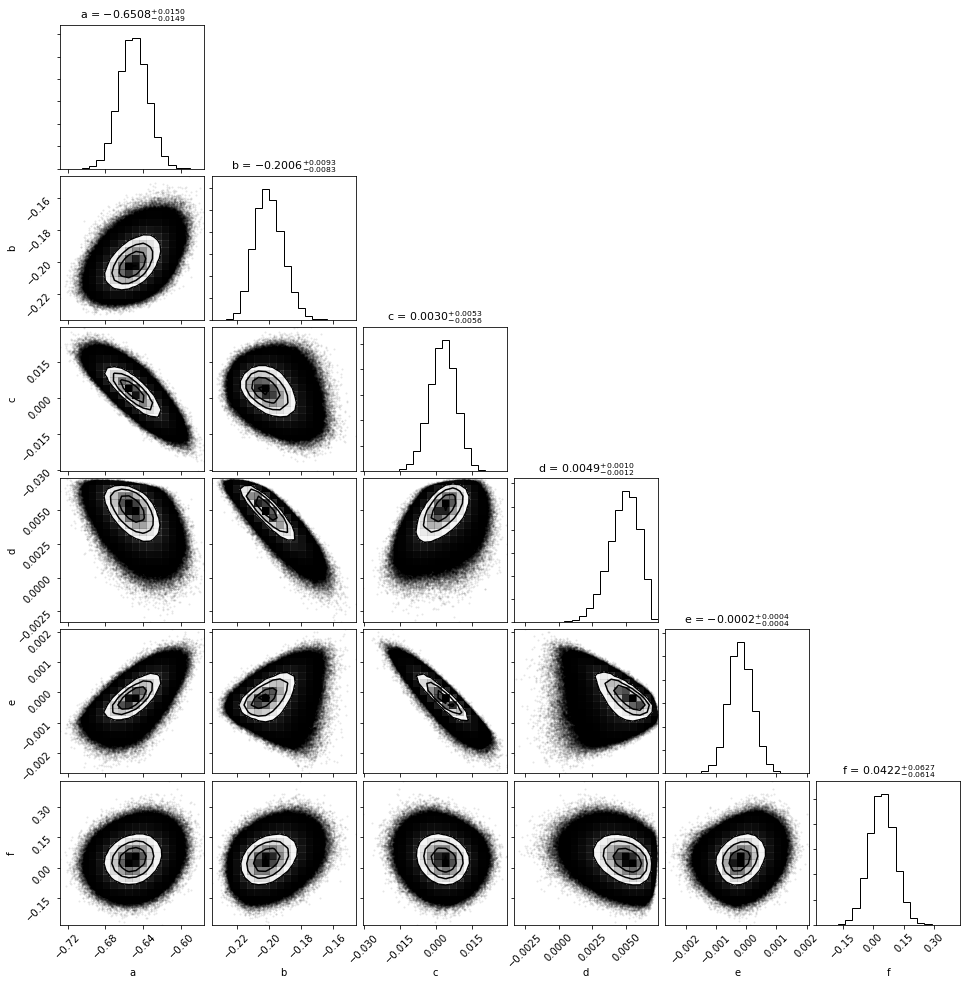

In [11]:
#print dat.shape,nwalkers,nsteps,thin
import corner
from matplotlib.backends.backend_pdf import PdfPages
dat = sampler.flatchain#chain
like = sampler.flatlnprobability
arr = dat

fig = corner.corner(arr[:,0:nvar], labels=['a',r'b','c',r'd',r'e',r'f'], show_titles=True, title_kwargs={"fontsize": 11},title_fmt='.4f')
pp = PdfPages('output_params_feh.pdf')
pp.savefig(fig)
pp.close()

In [12]:
dat = sampler.chain
prob = sampler.lnprobability
accept = sampler.acceptance_fraction
arr = dat.reshape((dat.shape)[0]*(dat.shape)[1],dat.shape[2])
print 'name plx_mcmc plx_err_mcmc plxinput plx_prior diff_sig1 diff_sig2'
for i in range(nvar,dat.shape[2]):
    print "{:10s}".format(name[i-nvar]), \
    i,\
    "{0:.4f}".format(np.median(arr[:,i])),"{0:.4f}".format(np.std(arr[:,i])),"{0:.4f}".format(plxprior[i-nvar]), \
    "{0:.4f}".format(plxval[i-nvar]),"{0:.4f}".format((plxval[i-nvar]-np.median(arr[:,i]))/plxprior[i-nvar]), \
    "{0:.4f}".format((plxval[i-nvar]-np.median(arr[:,i]))/np.sqrt(plxprior[i-nvar]**2+np.std(arr[:,i])**2))
    

name plx_mcmc plx_err_mcmc plxinput plx_prior diff_sig1 diff_sig2
GJ623      6 125.0072 0.2999 0.3000 125.0000 -0.0239 -0.0169
GJ4024     7 50.9088 1.4764 2.5000 50.1000 -0.3235 -0.2786
PMJ02133+3648 8 74.0251 2.9574 3.5000 74.6000 0.1643 0.1255
HIP11542   9 39.6277 0.7592 1.6000 38.2000 -0.8923 -0.8062
HD239960   10 250.0096 1.8849 1.9000 249.9000 -0.0577 -0.0410
HD15285    11 58.8837 0.8784 1.1000 58.3000 -0.5306 -0.4146
Gl844      12 61.2043 1.6658 2.2000 61.8000 0.2708 0.2159
HIP9724    13 109.2374 1.7992 1.8700 109.5900 0.1885 0.1359
Gl831      14 125.3015 0.3003 0.3000 125.3000 -0.0049 -0.0034
Gl804      15 48.4401 1.2195 2.1000 47.4000 -0.4953 -0.4283
Gl747      16 122.4436 2.3813 2.5000 122.3000 -0.0574 -0.0416
Gl695C     17 120.3331 0.1599 0.1600 120.3300 -0.0193 -0.0136
Gl660      18 86.3765 2.1343 2.4700 85.2300 -0.4642 -0.3512
Gl54       19 126.9062 0.3990 0.4000 126.9000 -0.0156 -0.0110
Gl494      20 85.4696 1.3501 1.5000 85.5000 0.0203 0.0151
Gl473      21 227.5216 4.4682

In [13]:
factor = (au**3.)*((4.0*np.pi**2.)/(g*msun))
mass = factor*smaper/plxval**3

mka = kp - 5.0*(np.log10(1000.0/plxval)-1.)
mkb = ks - 5.0*(np.log10(1000.0/plxval)-1.)

best = (like == max(like))
a = arr[best,0]#np.median(arr[:,0])
b = arr[best,1]#np.median(arr[:,1])
c = arr[best,2]#np.median(arr[:,2])
d = arr[best,3]#np.median(arr[:,3])
e = arr[best,4]#np.median(arr[:,4])
f = arr[best,5]
print a,b,c,d,e,f

mass1 = (10.0**(a + b*(mka-7.5) + c*(mka-7.5)**2 + d*(mka-7.5)**3 + e*(mka-7.5)**4))*(1+f*feh)
mass2 = (10.0**(a + b*(mkb-7.5) + c*(mkb-7.5)**2 + d*(mkb-7.5)**3 + e*(mkb-7.5)**4))*(1+f*feh)
sysmass = mass1+mass2
a, b, c, d, e = result1
mass1 = a + b*(mka-7.5) + c*(mka-7.5)**2 + d*(mka-7.5)**3 + e*(mka-7.5)**4
mass2 = a + b*(mkb-7.5) + c*(mkb-7.5)**2 + d*(mkb-7.5)**3 + e*(mkb-7.5)**4
sysmass_mann = mass1+mass2
a, b, c, d, e = result_ben
mass1 = a + b*(mka-7.5) + c*(mka-7.5)**2 + d*(mka-7.5)**3 + e*(mka-7.5)**4
mass2 = a + b*(mkb-7.5) + c*(mkb-7.5)**2 + d*(mkb-7.5)**3 + e*(mkb-7.5)**4
sysmass_ben = mass1+mass2

[-0.65717185] [-0.20518422] [ 0.00164248] [ 0.00538808] [ -2.52450470e-05] [ 0.00571719]


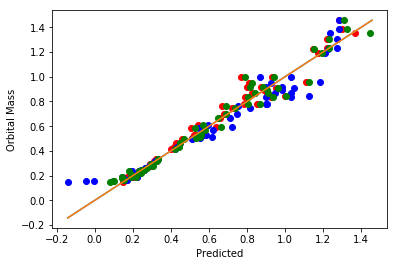

In [14]:
import matplotlib.pyplot as plt

rng = [np.min(np.concatenate([sysmass,sysmass_ben,mass])),
         np.max(np.concatenate([sysmass,sysmass_ben,mass]))]
plt.figure()
plt.plot(sysmass,mass,'ro')
plt.ylabel('Orbital Mass')
plt.xlabel('Predicted')
plt.plot(sysmass_ben,mass,'ro',color='b')
plt.plot(rng,rng)
plt.plot(sysmass_mann,mass,'ro',color='g')
plt.plot(rng,rng)
## blue = benedict
## green = mann idl
## red = python

50.9088145071 74.6
(6000000,) (6000000,)


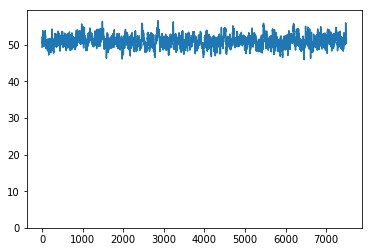

In [15]:
newprob = prob.reshape((prob.shape)[0]*(dat.shape)[1])
num = 7
plt.plot(dat[2,:,num])
print np.median(arr[:,num]),plxval[num-5]

#
print newprob.shape,arr[:,0].shape
n, bins, patches = plt.hist(newprob[np.isfinite(newprob)], 50, normed=1, facecolor='green', alpha=0.75)
plt.show()

[-0.65717185] [-0.20518422] [ 0.00164248] [ 0.00538808] [ -2.52450470e-05] [ 0.00571719]


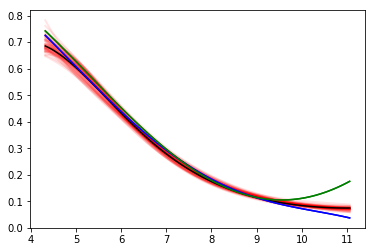

In [16]:
best = (like == max(like))
a = arr[best,0]#np.median(arr[:,0])
b = arr[best,1]#np.median(arr[:,1])
c = arr[best,2]#np.median(arr[:,2])
d = arr[best,3]#np.median(arr[:,3])
e = arr[best,4]#np.median(arr[:,3])
f = arr[best,5]

print a,b,c,d,e,f
rng = [np.min(np.concatenate([mka,mkb])),np.max(np.concatenate([mka,mkb]))]
mk = np.linspace(rng[0],rng[1],100)
mass1 = 10.0**(a + b*(mk-7.5) + c*(mk-7.5)**2 + d*(mk-7.5)**3 + e*(mk-7.5)**4)
a, b, c, d, e = result1
mass2 = a + b*(mk-7.5) + c*(mk-7.5)**2 + d*(mk-7.5)**3 + e*(mk-7.5)**4
mass3 = 0.585825902+3.87151019e-1*mk-1.21729937e-1*mk**2.+1.05529583e-2*mk**3.-2.72615872e-4*mk**4.

## red = new fit
## blue = Benedict
## green = How to constrain your M dwarf
#plt.plot(mk,mass1,color='o')
plt.plot(mk,mass2,color='b')
plt.plot(mk,mass3,color='g')


for i in range(0,60):
    index = np.random.randint(len(arr[:,0]))
    if np.isfinite(newprob[index]):
        a, b, c, d, e, f = arr[index,0:nvar]
        mass = (10.0**(a + b*(mk-7.5) + c*(mk-7.5)**2 + d*(mk-7.5)**3 + e*(mk-7.5)**4))*(1+f*(-0.1))
        plt.plot(mk,mass,color='r',lw=2,alpha=0.1)

plt.plot(mk,mass1,color='black')
plt.plot(mk,mass2,color='b')
plt.plot(mk,mass3,color='g')

plt.show()


In [17]:
## save out the relevant chains
import pyfits
pyfits.writeto('Mk-Mass_feh_emcee.fits', sampler.chain, clobber=True)
pyfits.writeto('Mk-Mass_feh_emcee_accept.fits', sampler.acceptance_fraction, clobber=True)
pyfits.writeto('Mk-Mass_feh_emcee_lnprob.fits', sampler.lnprobability, clobber=True)
pyfits.writeto('Mk-Mass_feh_emcee_acor.fits', sampler.acor, clobber=True)

/Users/amann/anaconda2/lib/python2.7/site-packages/pyfits/file.py:372: UserWarning: Overwriting existing file 'Mk-Mass_feh_emcee.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/amann/anaconda2/lib/python2.7/site-packages/pyfits/file.py:372: UserWarning: Overwriting existing file 'Mk-Mass_feh_emcee_accept.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)
/Users/amann/anaconda2/lib/python2.7/site-packages/pyfits/file.py:372: UserWarning: Overwriting existing file 'Mk-Mass_feh_emcee_lnprob.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


AutocorrError: The chain is too short to reliably estimate the autocorrelation time